In [1]:
%matplotlib notebook

import sys
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

In [2]:
# Set runningOnColab = True if you are running this a google colab session.
runningOnColab = False

if runningOnColab:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append('drive/My Drive/Colab Notebooks/electricity-theft-detection-with-self-attention')

In [2]:
import sys
sys.path.append('/Users/ivan_zorin/Documents/AIRI/code/electricity-theft-detection-with-self-attention/')

from dataset import FraudDataset
from CNN_model import CNNModel
from Att_Augmented_Google_model import GoogleFullModel
from Hybrid_Attn import HybridAttentionModel
from train import perform_kfold_cv
from radam import RAdam
from data import download_data,get_processed_dataset

In [3]:
# download_data()
data_path = '/Users/ivan_zorin/Documents/AIRI/data/sgcc/data.csv'
df = get_processed_dataset(data_path)
df.head()

,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,2014-01-09 00:00:00,2014-01-10 00:00:00,2014-01-11 00:00:00,2014-01-12 00:00:00,2014-01-13 00:00:00,2014-01-14 00:00:00,2014-01-15 00:00:00,...,2016-10-23 00:00:00,2016-10-24 00:00:00,2016-10-25 00:00:00,2016-10-26 00:00:00,2016-10-27 00:00:00,2016-10-28 00:00:00,2016-10-29 00:00:00,2016-10-30 00:00:00,2016-10-31 00:00:00,flags
CONS_NO,,,,,,,,,,,,,,,,,,,,,
0387DD8A07E07FDA6271170F86AD9151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.681194,0.730050,0.782126,0.563406,0.720588,0.736546,0.689447,0.779210,0.674491,1
01D6177B5D4FFE0CABA9EF17DAFC2B84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4B75AC4F2D8434CFF62DB64D0BB43103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.888909,0.888927,0.888920,0.888948,0.888914,0.888908,0.888908,0.888900,0.888901,1
B32AC8CC6D5D805AC053557AB05F5343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.871700,0.888922,0.888898,0.888932,0.888927,0.888903,0.888931,0.888902,0.865038,1
EDFC78B07BA2908B3395C4EB2304665E,0.610321,0.590786,0.526703,0.520408,0.529022,0.547222,0.566903,0.505787,0.550109,0.519241,...,0.765607,0.748578,0.610797,0.600845,0.626157,0.664422,0.814228,0.799255,0.777778,1


In [4]:
if torch.cuda.is_available():
    device = 'cuda' 
elif torch.backends.mps.is_available():
    device = 'mps'
else: 
    device = 'cpu'

print(f'Using {device}')

Using mps


In [5]:
random_state   = 12
reproductivity = True

if reproductivity:
    manualSeed = 13

    np.random.seed(manualSeed)
    torch.manual_seed(manualSeed)

    # If using GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(manualSeed)
        torch.cuda.manual_seed_all(manualSeed)

    torch.backends.cudnn.enabled = False 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    print('Reproducing experiment with seed:',manualSeed)
    print('Using random state:',random_state)

else:
    print('Random Experiment')
    
k_folds = 5
lr = 0.001
models = [HybridAttentionModel().to(device) for _ in range(k_folds)]
optims = [RAdam(model.parameters(), lr) for model in models]
criterion = nn.CrossEntropyLoss()

Reproducing experiment with seed: 13
Using random state: 12


In [ ]:
f1_per_fold = perform_kfold_cv(df, models, optims, criterion, k_folds, device=device, n_epochs=1)

In [6]:
drive_path = '/Users/ivan_zorin/Google Drive/My Drive/4. MODELS/NTL'

with open(os.path.join(drive_path, 'f1_results.pkl'), 'rb') as f:
    f1_per_fold = pickle.load(f)


best_fold = f1_per_fold.index(sorted(f1_per_fold, key=lambda x:x[0], reverse=True)[0]) + 1

best_f1, best_epoch,_,_ = f1_per_fold[best_fold-1]
print(f'The best fold ,was {best_fold} with F1 of {best_f1} at epoch {best_epoch}')


models_path = os.path.join(drive_path, 'att_models')

model = HybridAttentionModel().to(device)
model.load_state_dict(torch.load(os.path.join(models_path, f'fold_{best_fold}', f'epoch_{best_epoch}.pth'), map_location=device))

The best fold ,was 4 with F1 of 0.08538163001293661 at epoch 1


<All keys matched successfully>

In [7]:
dataset = FraudDataset(df.to_numpy()[:, :-1], df['flags'].to_numpy())
loader = DataLoader(dataset=dataset, batch_size=1, shuffle=False)

x, y = next(iter(loader))

In [8]:
embedding_model = nn.Sequential(list(model.children())[0]).to(device)
embedding_model.eval()

classifier_model = nn.Sequential(*list(model.classifier.children())[:3]).to(device)
classifier_model.eval()

Sequential(
  (0): Linear(in_features=49392, out_features=1024, bias=True)
  (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): PReLU(num_parameters=1)
)

In [9]:
N, C, _ = x.shape
x = x.view(N, C, 147, -1)
emb = embedding_model(x.to(device))

In [10]:
out = classifier_model(emb.view(N, -1))

In [11]:
def plot_coordinates(coord, labels, title=''):
    plt.figure()
    sns.scatterplot(x=coord[labels==0, 0], y=coord[labels==0, 1], color='b', alpha=0.2, label='norm')
    sns.scatterplot(x=coord[labels==1, 0], y=coord[labels==1, 1], color='r', marker='x', label='bad')
    plt.legend()
    plt.title(title)
    plt.show()

In [13]:
# whole model

coord = []
labels = []
for x, y in tqdm(loader):
    # N, C, _ = x.shape
    # x = x.view(N, C, 147, -1)
    out = model(x.to(device))
    coord.append(out.detach().cpu().numpy())
    labels.append(y.item())

coord = np.concatenate(coord)
labels = np.array(labels)
assert coord.shape[0] == labels.shape[0]


100%|██████████| 42372/42372 [04:15<00:00, 166.05it/s]


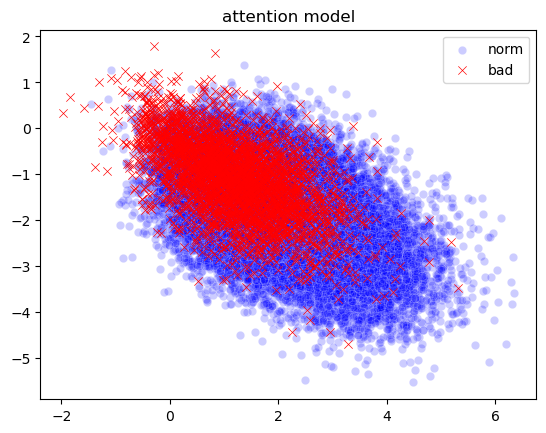

In [15]:
plot_coordinates(coord, labels, 'attention model')

In [16]:
# embedder and first layer of classifier

coord = []
labels = []
for x, y in tqdm(loader):
    N, C, _ = x.shape
    x = x.view(N, C, 147, -1)
    out = embedding_model(x.to(device))
    out = classifier_model(out.view(N, -1))

    coord.append(out.detach().cpu().numpy())
    labels.append(y.item())

coord = np.concatenate(coord)
labels = np.array(labels)
assert coord.shape[0] == labels.shape[0]

100%|██████████| 42372/42372 [04:23<00:00, 160.86it/s]


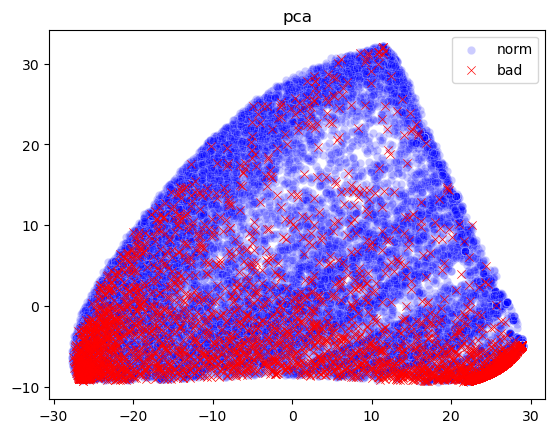

In [18]:
coord_pca = PCA(2).fit_transform(coord)
plot_coordinates(coord_pca, labels, 'pca')

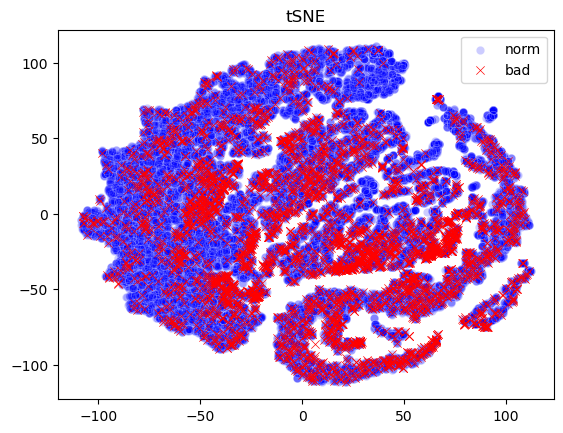

In [19]:
coord_tsne = TSNE(2).fit_transform(coord)
plot_coordinates(coord_tsne, labels, 'tSNE')

In [12]:
# embedder only
embedding_model.eval()
coord = []
labels = []
for x, y in tqdm(loader):
    N, C, _ = x.shape
    x = x.view(N, C, 147, -1)
    out = embedding_model(x.to(device)).view(N, -1)

    coord.append(out.detach().cpu().numpy())
    labels.append(y.item())

coord = np.concatenate(coord)
labels = np.array(labels)
assert coord.shape[0] == labels.shape[0]

100%|██████████████████████████████████████████████████████████████| 42372/42372 [03:22<00:00, 209.53it/s]


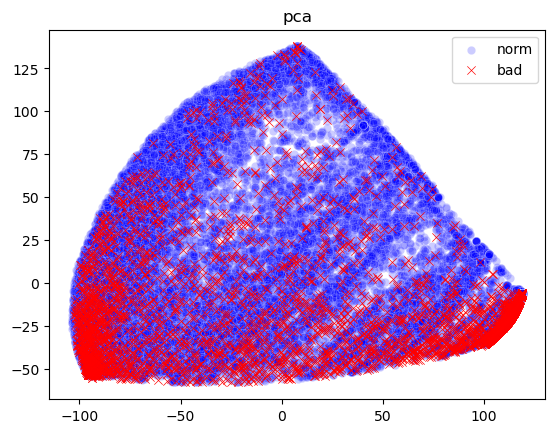

In [21]:
coord_pca = PCA(2).fit_transform(coord)
plot_coordinates(coord_pca, labels, 'pca')

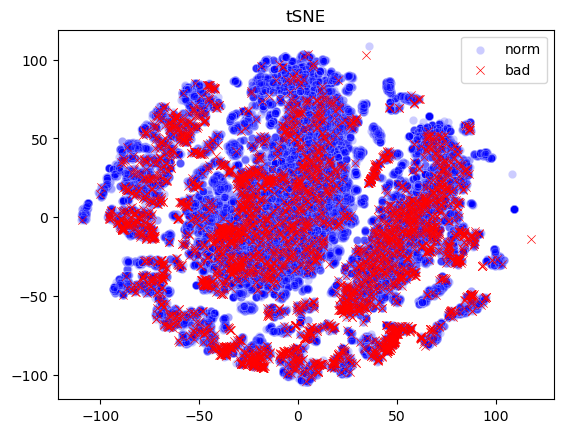

In [22]:
coord_tsne = TSNE(2).fit_transform(coord)
plot_coordinates(coord_tsne, labels, 'tSNE')

In [13]:
coord_pca3d = PCA(3).fit_transform(coord)

In [23]:
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

x0 = coord_pca3d[labels == 0, 0]
y0 = coord_pca3d[labels == 0, 1]
z0 = coord_pca3d[labels == 0, 2]

x1 = coord_pca3d[labels == 1, 0]
y1 = coord_pca3d[labels == 1, 1]
z1 = coord_pca3d[labels == 1, 2]

fig = plt.figure()
# ax = plt.axes(projection ="3d")
ax = Axes3D(fig)
ax.scatter3D(x0, y0, z0, color = "b", marker='o', alpha=0.3)
ax.scatter3D(x1, y1, z1, color = "r", marker='x', alpha=0.5)


fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

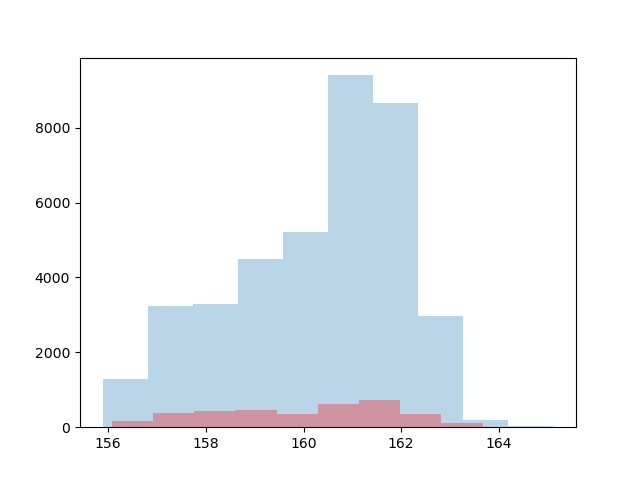

In [29]:
norm = np.linalg.norm(coord, axis=1)


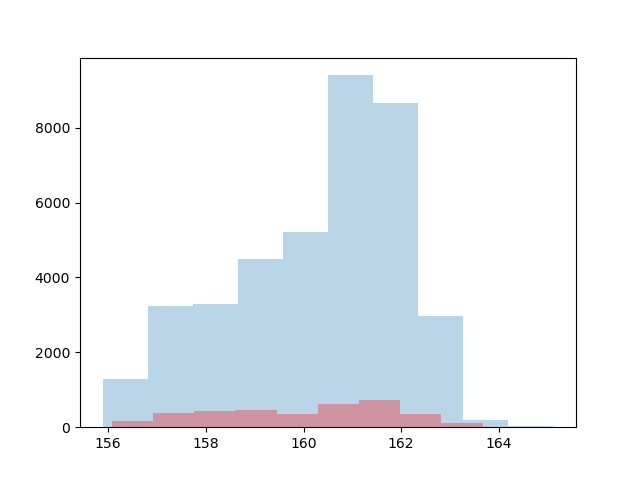

In [33]:

fig = plt.figure()
plt.hist(norm[labels==0], alpha=0.3)
plt.hist(norm[labels==1], color='r', alpha=0.3)
plt.show()

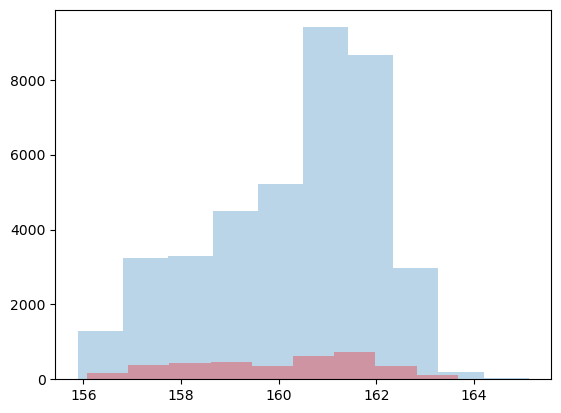

In [34]:
fig